In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from predecon import PreDeCon
from sklearn.metrics import normalized_mutual_info_score as NMI

Clusters found: 4

Performance:
  0.1676s en
  0.1680s cn
  0.0032s spm
  0.0025s csm
  0.0137s gpwsm
  0.0283s pwen
  0.0284s cwn
  0.0208s spd
  0.0170s icp
  0.3472s idpwr
  0.5706s cc
  0.7727s fit



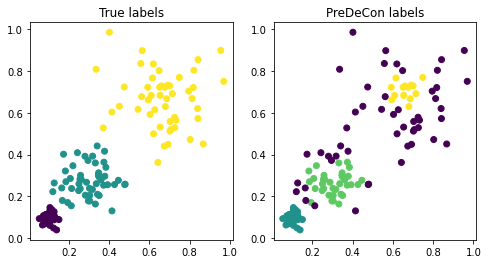

In [3]:
dataset = 'mouse'

ds_params = {
   'pov': {'minPts': 8, 'eps': 0.7, 'delta': 0.5, 'lambda_': 2, 'kappa': 100},
   'mouse': {'minPts': 25, 'eps': 0.725, 'delta': 0.3, 'lambda_': 2, 'kappa': 100}
}

path = os.path.join('..', 'algorithm_verification', 'datasets', dataset, dataset + '.csv')

data = np.loadtxt(path, delimiter=' ')
X, true_labels = data[:,:-1], data[:,-1]

predecon = PreDeCon(**ds_params[dataset])
predecon.fit(X)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=true_labels)
ax[0].set_title("True labels")

ax[1].scatter(X[:,0], X[:,1], c=predecon.labels)
ax[1].set_title("PreDeCon labels")

print("Clusters found:",  len(set(predecon.labels)))
print("\nPerformance:")
print(predecon.performance())